Models to test
1. naive bayes
2. knn
3. decision tree / random forest
4. SVM
5. SGD classifier

todo <br/>
preprocessing : <br/>
    &nbsp;&nbsp;&nbsp;1. Scaling 
<br/>
check all the models <br/>
error analysis <br/>
pipelines <br/>

In [29]:
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import set_config

from IPython.display import display

from tqdm import tqdm

import cv2 as cv
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def fetch_db():
    maindf = fetch_openml('mnist_784', version=1)
    return maindf['data'], maindf['target']

x,y = fetch_db()

In [3]:
display(x.shape)
display(y.shape)

(70000, 784)

(70000,)

In [4]:
def plot_digit(digit):
    dig = digit.to_numpy().reshape(28,28)
    plt.imshow(dig)

<h2>Pre processing</h2>

Denoising

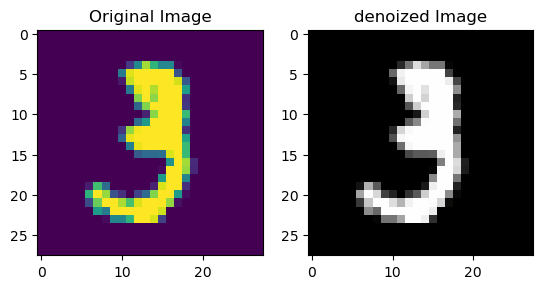

In [5]:
dig = x.iloc[10,:].to_numpy().reshape(28,28)
img_rgb = cv.cvtColor(dig.astype(np.uint8),cv.COLOR_GRAY2RGB)
img = cv.fastNlMeansDenoisingColored(img_rgb,None,10,10,7,21)

plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(dig)

plt.subplot(1,2,2)
plt.title('denoized Image')
plt.imshow(img)


we can see that denoising doesnt have much effect

Image sharpening

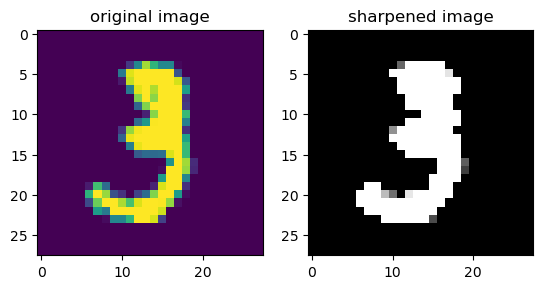

In [6]:
dig = x.iloc[10,:].to_numpy().reshape(28,28)
kernel = np.array([[0, -1, 0],
                   [-1, 11, -1],
                   [0, -1, 0]
])
img_rgb = cv.cvtColor(dig.astype(np.uint8),cv.COLOR_GRAY2RGB)
img_sharpen = cv.filter2D(img_rgb,-1,kernel)

plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(dig)

plt.subplot(1,2,2)
plt.title("sharpened image")
plt.imshow(img_sharpen)

ok we will use image sharpening lets write a function for this

In [7]:
tqdm.pandas()
def sharpen_image(row):
    dig = row.to_numpy().reshape(28,28)
    kernel = np.array([[0, -1, 0],
                       [-1, 11, -1],
                       [0, -1, 0]
    ])
    img_rgb = cv.cvtColor(dig.astype(np.uint8),cv.COLOR_GRAY2RGB)
    img_sharpen = cv.filter2D(img_rgb,-1,kernel)
    img_sharp_gray = cv.cvtColor(img_sharpen, cv.COLOR_RGB2GRAY)
    return img_sharp_gray.flatten()
 
x_sharpened = x.progress_apply(sharpen_image, axis=1, result_type="broadcast")

100%|██████████| 70000/70000 [00:04<00:00, 16847.33it/s]


normalization

(70000, 784)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


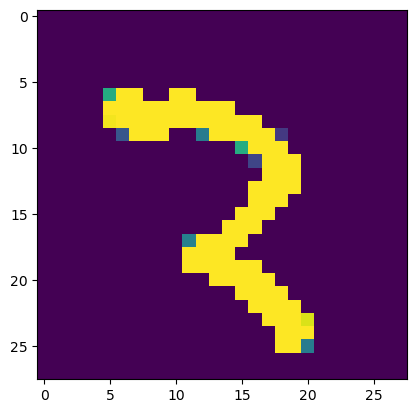

In [8]:
display(x_sharpened.shape)
display(x_sharpened.head())
plt.imshow(x_sharpened.iloc[500,:].to_numpy().reshape(28,28))

In [9]:
display(x.describe())
display(y.describe())
y.value_counts()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.197414,0.099543,0.046629,0.016614,0.012957,0.001714,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.991206,4.256304,2.783732,1.561822,1.553796,0.320889,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


count     70000
unique       10
top           1
freq       7877
Name: class, dtype: object

class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64

In [10]:
x_norm_sharp = x_sharpened.astype('float32')/255
x_norm_sharp.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,70000.0,...,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.0,70000.0,70000.0,70000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001186,0.000587,0.000278,0.000114,0.000075,0.000029,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033907,0.023819,0.016546,0.010281,0.008329,0.005345,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0


In [11]:
x_train_sharp_norm, x_test_sharp_norm, y_train_sharp_norm, y_test_sharp_norm = x_norm_sharp.iloc[:63000,:], x_norm_sharp.iloc[63000:,:], y.iloc[:63000], y.iloc[63000:]
display(x_train_sharp_norm.shape)
display(x_test_sharp_norm.shape)

(63000, 784)

(7000, 784)

<h2>Model training and evaluation</h2>

Gaussian Classifier

In [14]:
nb_classifier = GaussianNB()
y_pred_nb = cross_val_predict(nb_classifier, x_train_sharp_norm, y_train_sharp_norm, cv=5)

0.5476984126984127

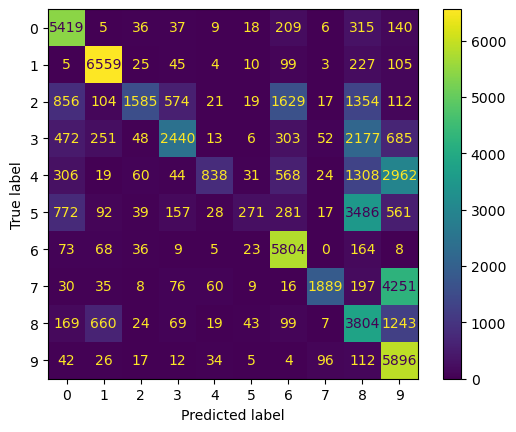

In [15]:
display(accuracy_score(y_train_sharp_norm, y_pred_nb))
ConfusionMatrixDisplay(confusion_matrix(y_train_sharp_norm, y_pred_nb)).plot()

Naive bayes is not the way to go <br/>
Lets try Kneighbordclassifier

todo compare k = 4 to 10 (f1 score, recall, precision)

In [14]:
f1=[]
pre=[]
rec=[]
def list_scores_knn(start, end, f1, pre, rec):
    for i in range(start, end):
        knn_classifier = KNeighborsClassifier(n_neighbors=i)
        y_pred_knn = cross_val_predict(knn_classifier, x_train_sharp_norm, y_train_sharp_norm, cv=3)
        f1.append(f1_score(y_train_sharp_norm, y_pred_knn, average='macro'))
        pre.append(precision_score(y_train_sharp_norm, y_pred_knn, average='macro'))
        rec.append(recall_score(y_train_sharp_norm, y_pred_knn, average='macro'))
        print(i)
    f1 = np.array(f1)
    pre = np.array(pre)
    rec = np.array(rec)

[]

[]

[]

ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

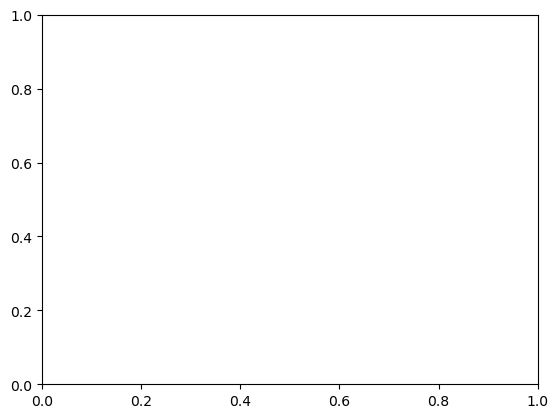

In [15]:
display(f1)
display(rec)
display(pre)

plt.plot(np.arange(4, 11), pre, label='pre', color='r', linestyle='-.', marker='s')
plt.plot(np.arange(4, 11), f1, label='F1', color='b', linestyle='-', marker='o') 
plt.plot(np.arange(4, 11), rec, label='rec', color='g', linestyle='--', marker='x')
plt.legend()

checking both k=4 and k=5

as K = 4

In [16]:
knn_classifier = KNeighborsClassifier(n_neighbors=4)
y_pred_knn = cross_val_predict(knn_classifier, x_train_sharp_norm, y_train_sharp_norm, cv=3)

0.9661904761904762

0.9659269908474337

0.966672035931779

0.9656404008105678

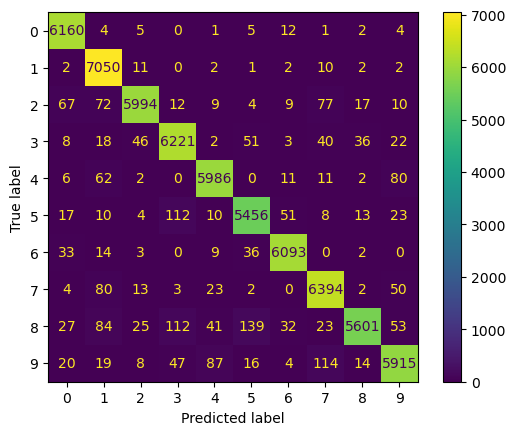

In [ ]:
display(accuracy_score(y_train_sharp_norm, y_pred_knn))
cf_matrix = confusion_matrix(y_train_sharp_norm, y_pred_knn)
ConfusionMatrixDisplay(cf_matrix).plot()
display(f1_score(y_train_sharp_norm, y_pred_knn, average='macro'))
display(precision_score(y_train_sharp_norm, y_pred_knn, average='macro'))
display(recall_score(y_train_sharp_norm, y_pred_knn, average='macro'))

as k=5

In [ ]:
knn5_classifier = KNeighborsClassifier(n_neighbors=5)
y_pred_knn5 = cross_val_predict(knn5_classifier, x_train_sharp_norm, y_train_sharp_norm, cv=3)

0.967031746031746

0.9668179433665467

0.9674859194353218

0.966560096697829

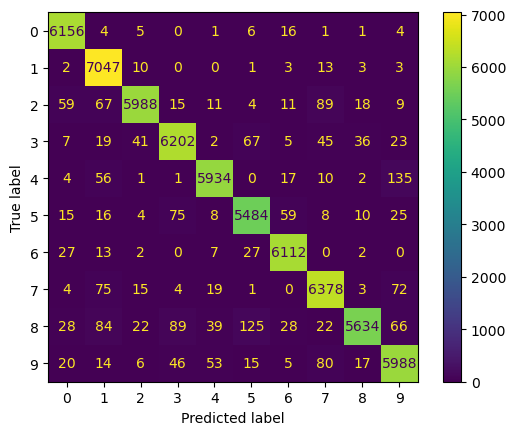

In [ ]:
display(accuracy_score(y_train_sharp_norm, y_pred_knn5))
cf_matrix5 = confusion_matrix(y_train_sharp_norm, y_pred_knn5)
ConfusionMatrixDisplay(cf_matrix5).plot()
display(f1_score(y_train_sharp_norm, y_pred_knn5, average='macro'))
display(precision_score(y_train_sharp_norm, y_pred_knn5, average='macro'))
display(recall_score(y_train_sharp_norm, y_pred_knn5, average='macro'))

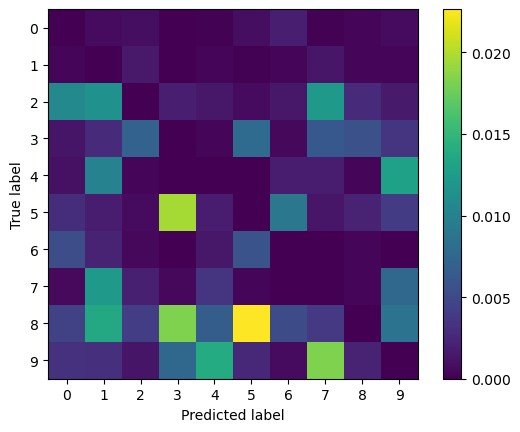

In [63]:
row_sums = cf_matrix.sum(axis=1, keepdims=True)
cf_matrix = cf_matrix/row_sums
np.fill_diagonal(cf_matrix,0)
ConfusionMatrixDisplay(cf_matrix).plot(include_values=False)

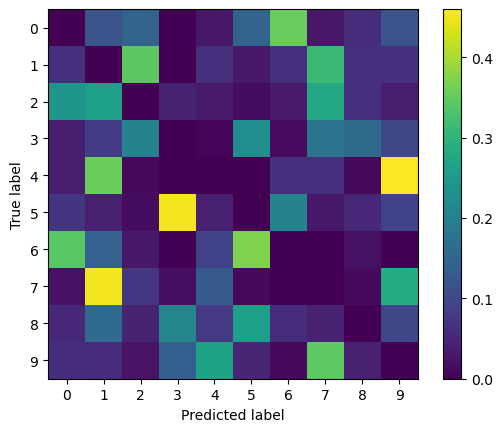

In [65]:
row_sums = cf_matrix5.sum(axis=1, keepdims=True)
cf_matrix5 = cf_matrix5/row_sums
np.fill_diagonal(cf_matrix5,0)
ConfusionMatrixDisplay(cf_matrix5).plot(include_values=False)

In [93]:
misclassified = []
for i in range(len(y_train_sharp_norm)):
    if (y_train_sharp_norm.iloc[i] == '8') and (y_pred_knn[i] == '5'):
        misclassified.append(True)
    else:
        misclassified.append(False)
misclassified_y = y_train_sharp_norm[misclassified]
misclassified_y_pred = y_pred_knn[misclassified]
misclassified_reg = x.iloc[:63000,:]
misclassified_reg = misclassified_reg[misclassified]
misclassified_x = x_train_sharp_norm[misclassified]


In [84]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

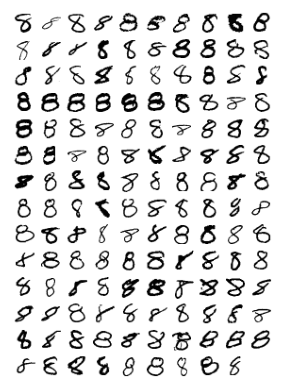

In [94]:
# i = 6
# plot_digit(misclassified_as_1_x.iloc[i,:])
# display(misclassified_as_1_y.iloc[i])
# display(misclassified_as_1_y_pred[i])

plot_digits(misclassified_x.iloc[:150,:])

In [110]:
rf_classifier = RandomForestClassifier(n_estimators=200)
y_pred_rf = cross_val_predict(rf_classifier, x_train_sharp_norm, y_train_sharp_norm)

0.9672857142857143

0.9670419504619107

0.9670441162056745

0.9670740217122658

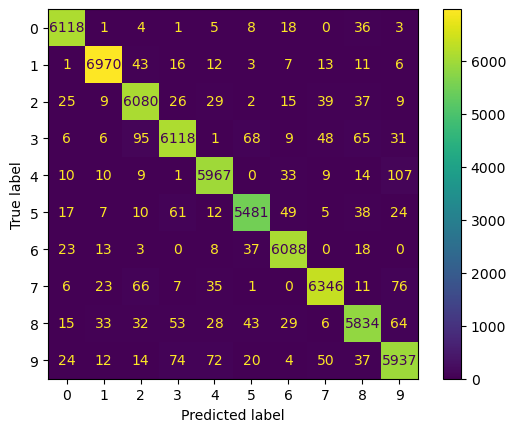

In [111]:
display(accuracy_score(y_train_sharp_norm, y_pred_rf))
cf_matrix_rf = confusion_matrix(y_train_sharp_norm, y_pred_rf)
ConfusionMatrixDisplay(cf_matrix_rf).plot()
display(f1_score(y_train_sharp_norm, y_pred_rf, average='macro'))
display(precision_score(y_train_sharp_norm, y_pred_rf, average='macro'))
display(recall_score(y_train_sharp_norm, y_pred_rf, average='macro'))

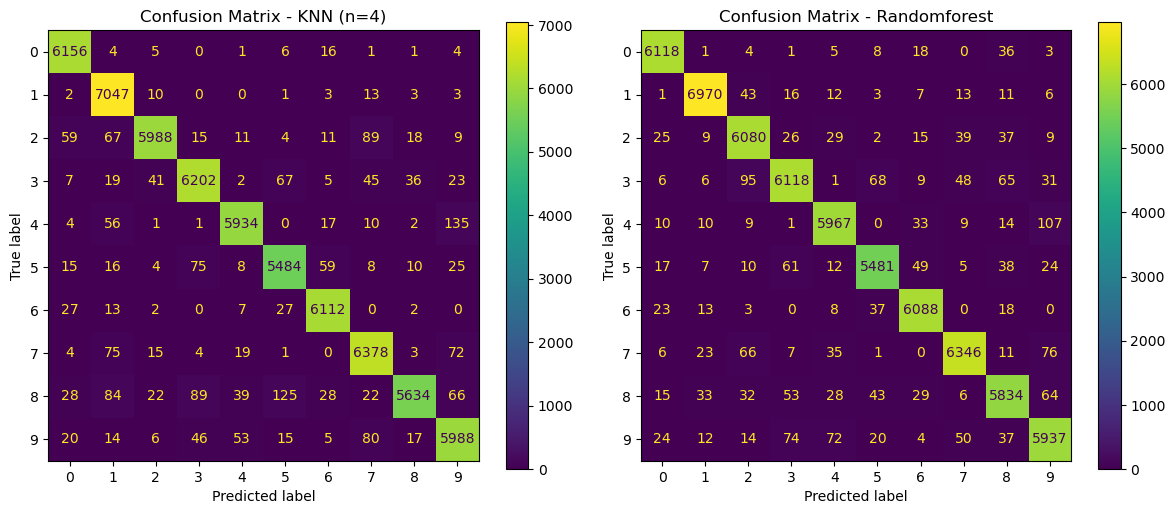

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cf_matrix5).plot(ax=ax[0])
ax[0].set_title("Confusion Matrix - KNN (n=4)")
ConfusionMatrixDisplay(cf_matrix_rf).plot(ax=ax[1])
ax[1].set_title("Confusion Matrix - Randomforest")
plt.tight_layout()

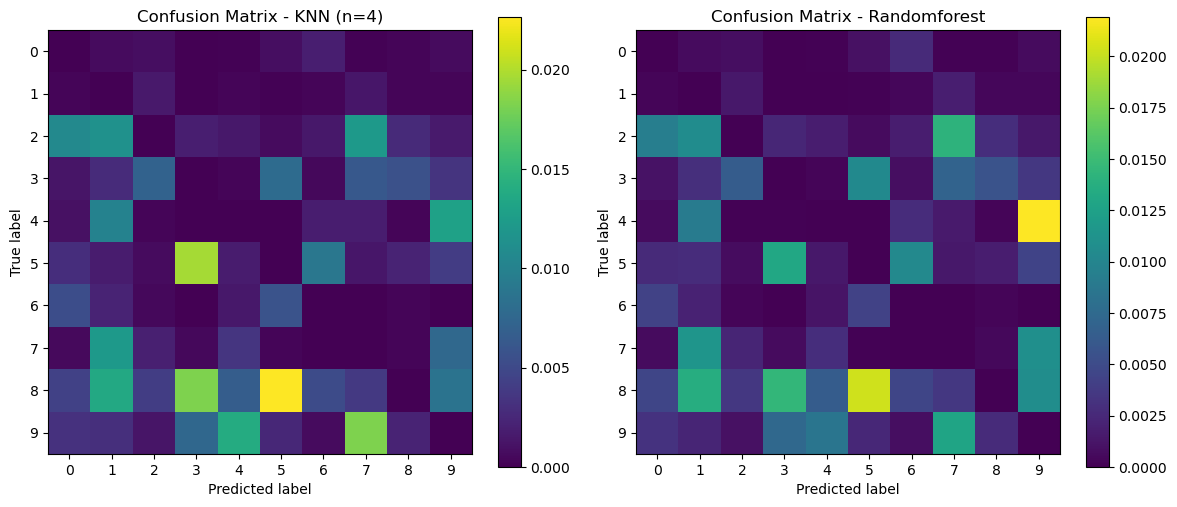

In [123]:
row_sums = cf_matrix.sum(axis=1, keepdims=True)
cf_matrixnorm = cf_matrix/row_sums
np.fill_diagonal(cf_matrixnorm,0)

row_sums = cf_matrix_rf.sum(axis=1, keepdims=True)
cf_matrix_rf_norm = cf_matrix5/row_sums
np.fill_diagonal(cf_matrix_rf_norm,0)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cf_matrixnorm).plot(ax=ax[0], include_values=False)
ax[0].set_title("Confusion Matrix - KNN (n=4)")
ConfusionMatrixDisplay(cf_matrix_rf_norm).plot(ax=ax[1], include_values=False)
ax[1].set_title("Confusion Matrix - Randomforest")
plt.tight_layout()

From this we can say that <br/>
1. KNN mispredicts 5 as 3 more than rf
2. knn mispredicts 8 as 5 more than rf
3. rf mispredicts 4 as 9 more than knn
4. knn mispredicts 9 as 7 more than rf
4. knn mispredicts 9 as 4 more than rf
<br/>
from this during ensemble learning we can assign more weight to rf for numbers like 9, 5, 8 and more weight to knn for 4, 7

Next Let's try SVM

In [126]:
svc_classifier = SVC()
y_pred_svc = cross_val_predict(svc_classifier, x_train_sharp_norm, y_train_sharp_norm)

0.9768412698412698

0.976676830412272

0.9767114765913114

0.976662506741645

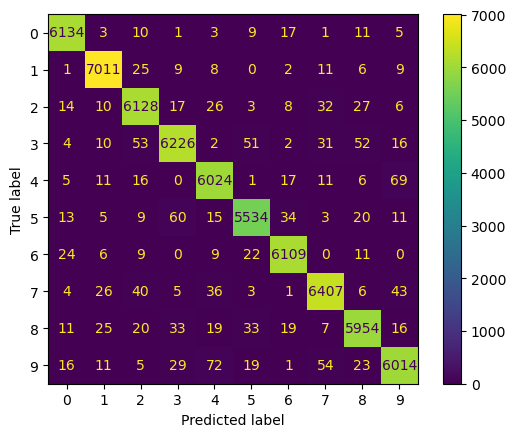

In [127]:
display(accuracy_score(y_train_sharp_norm, y_pred_svc))
cf_matrix_svc = confusion_matrix(y_train_sharp_norm, y_pred_svc)
ConfusionMatrixDisplay(cf_matrix_svc).plot()
display(f1_score(y_train_sharp_norm, y_pred_svc, average='macro'))
display(precision_score(y_train_sharp_norm, y_pred_svc, average='macro'))
display(recall_score(y_train_sharp_norm, y_pred_svc, average='macro'))

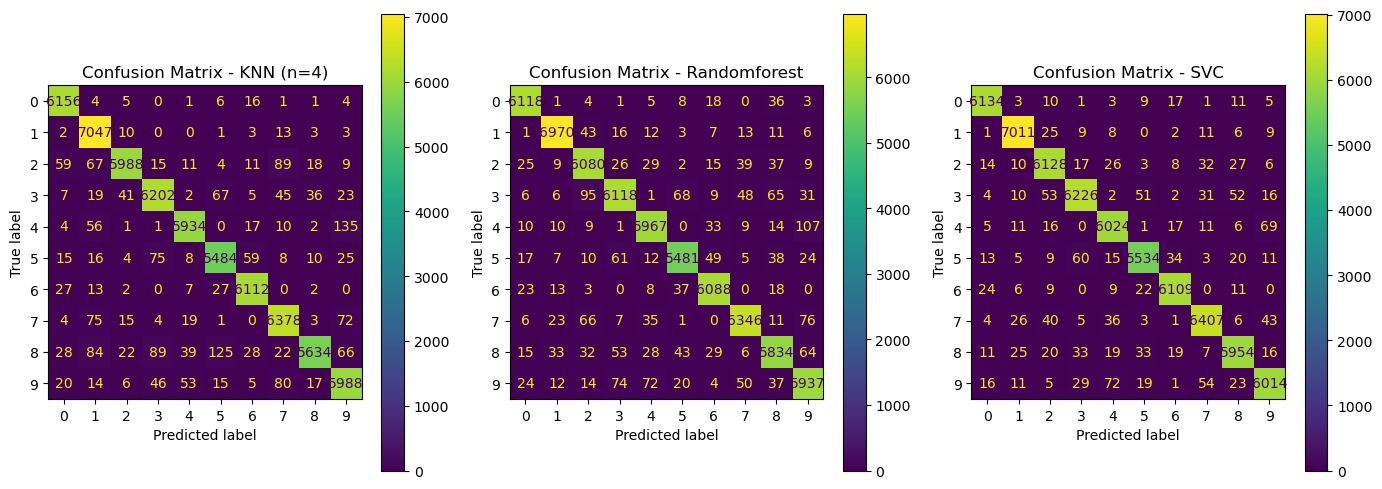

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ConfusionMatrixDisplay(cf_matrix5).plot(ax=ax[0])
ax[0].set_title("Confusion Matrix - KNN (n=4)")
ConfusionMatrixDisplay(cf_matrix_rf).plot(ax=ax[1])
ax[1].set_title("Confusion Matrix - Randomforest")
ConfusionMatrixDisplay(cf_matrix_svc).plot(ax=ax[2])
ax[2].set_title("Confusion Matrix - SVC")
plt.tight_layout()

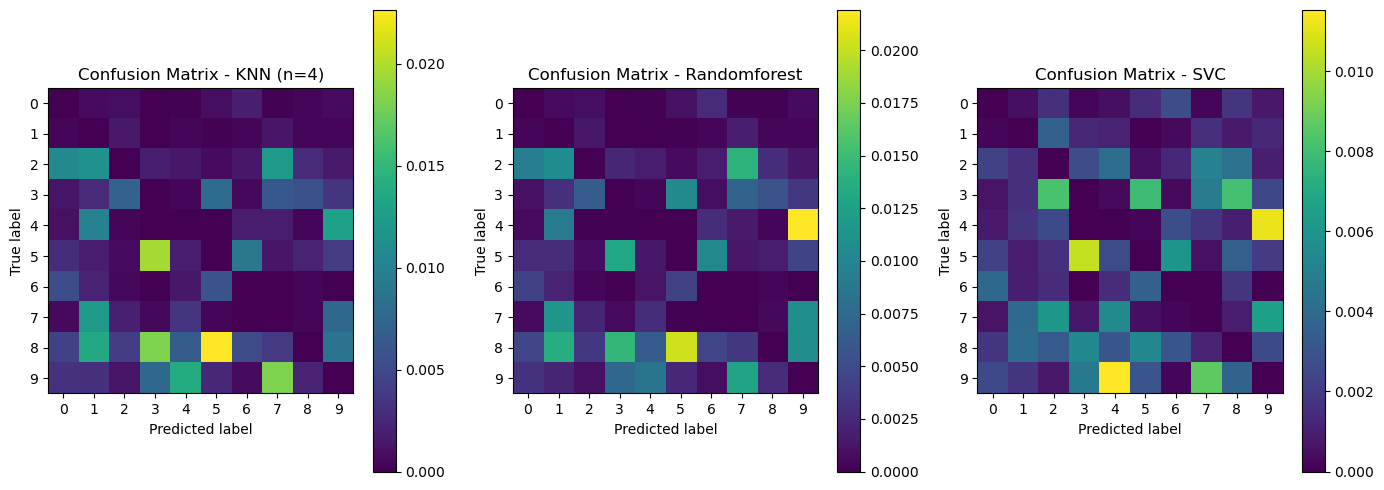

In [132]:
row_sums = cf_matrix_svc.sum(axis=1, keepdims=True)
cf_matrix_svc_norm = cf_matrix_svc/row_sums
np.fill_diagonal(cf_matrix_svc_norm,0)

fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ConfusionMatrixDisplay(cf_matrixnorm).plot(ax=ax[0], include_values=False)
ax[0].set_title("Confusion Matrix - KNN (n=4)")
ConfusionMatrixDisplay(cf_matrix_rf_norm).plot(ax=ax[1], include_values=False)
ax[1].set_title("Confusion Matrix - Randomforest")
ConfusionMatrixDisplay(cf_matrix_svc_norm).plot(ax=ax[2], include_values=False)
ax[2].set_title("Confusion Matrix - SVC")
plt.tight_layout()

From this we can say that while SVC make similar errors as rf and knn but overall svc is better than knn and randomforest

Lets try one final model : SGD classifier

In [135]:
sgd_classifier = SGDClassifier()
y_pred_sgd = cross_val_predict(sgd_classifier, x_train_sharp_norm, y_train_sharp_norm, cv=3)

0.878968253968254

0.8770968581632566

0.8791069657686539

0.8769485878029837

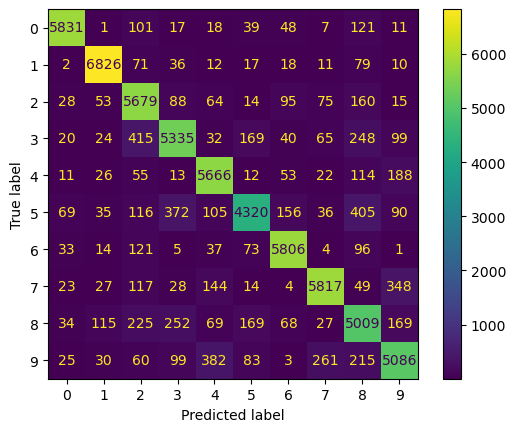

In [143]:
display(accuracy_score(y_train_sharp_norm, y_pred_sgd))
cf_matrix_sgd = confusion_matrix(y_train_sharp_norm, y_pred_sgd)
ConfusionMatrixDisplay(cf_matrix_sgd).plot()
display(f1_score(y_train_sharp_norm, y_pred_sgd, average='macro'))
display(precision_score(y_train_sharp_norm, y_pred_sgd, average='macro'))
display(recall_score(y_train_sharp_norm, y_pred_sgd, average='macro'))

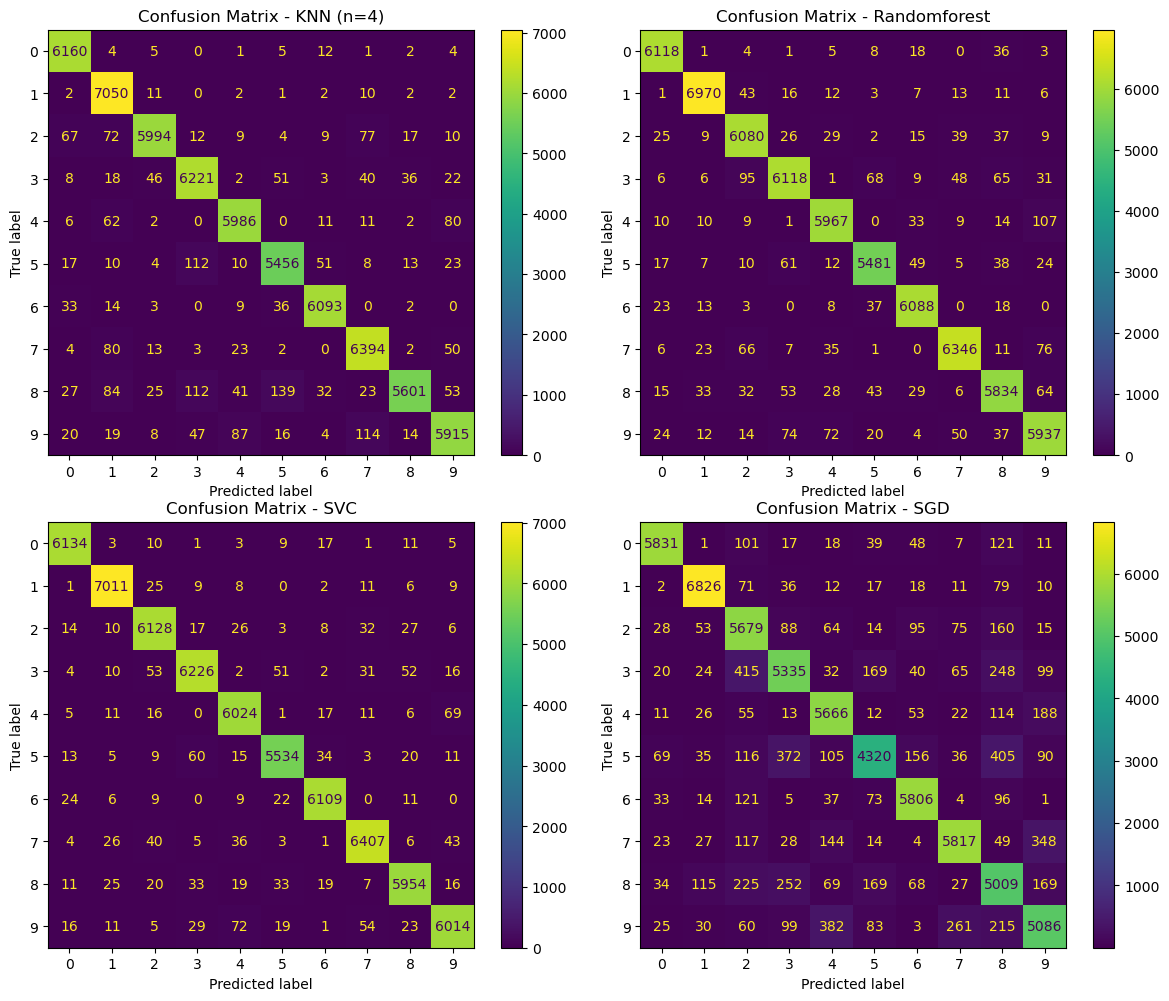

In [149]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ConfusionMatrixDisplay(cf_matrix).plot(ax=ax[0,0])
ax[0,0].set_title("Confusion Matrix - KNN (n=4)")
ConfusionMatrixDisplay(cf_matrix_rf).plot(ax=ax[0,1])
ax[0,1].set_title("Confusion Matrix - Randomforest")
ConfusionMatrixDisplay(cf_matrix_svc).plot(ax=ax[1,0])
ax[1,0].set_title("Confusion Matrix - SVC")
ConfusionMatrixDisplay(cf_matrix_sgd).plot(ax=ax[1,1])
ax[1,1].set_title("Confusion Matrix - SGD")
plt.tight_layout()

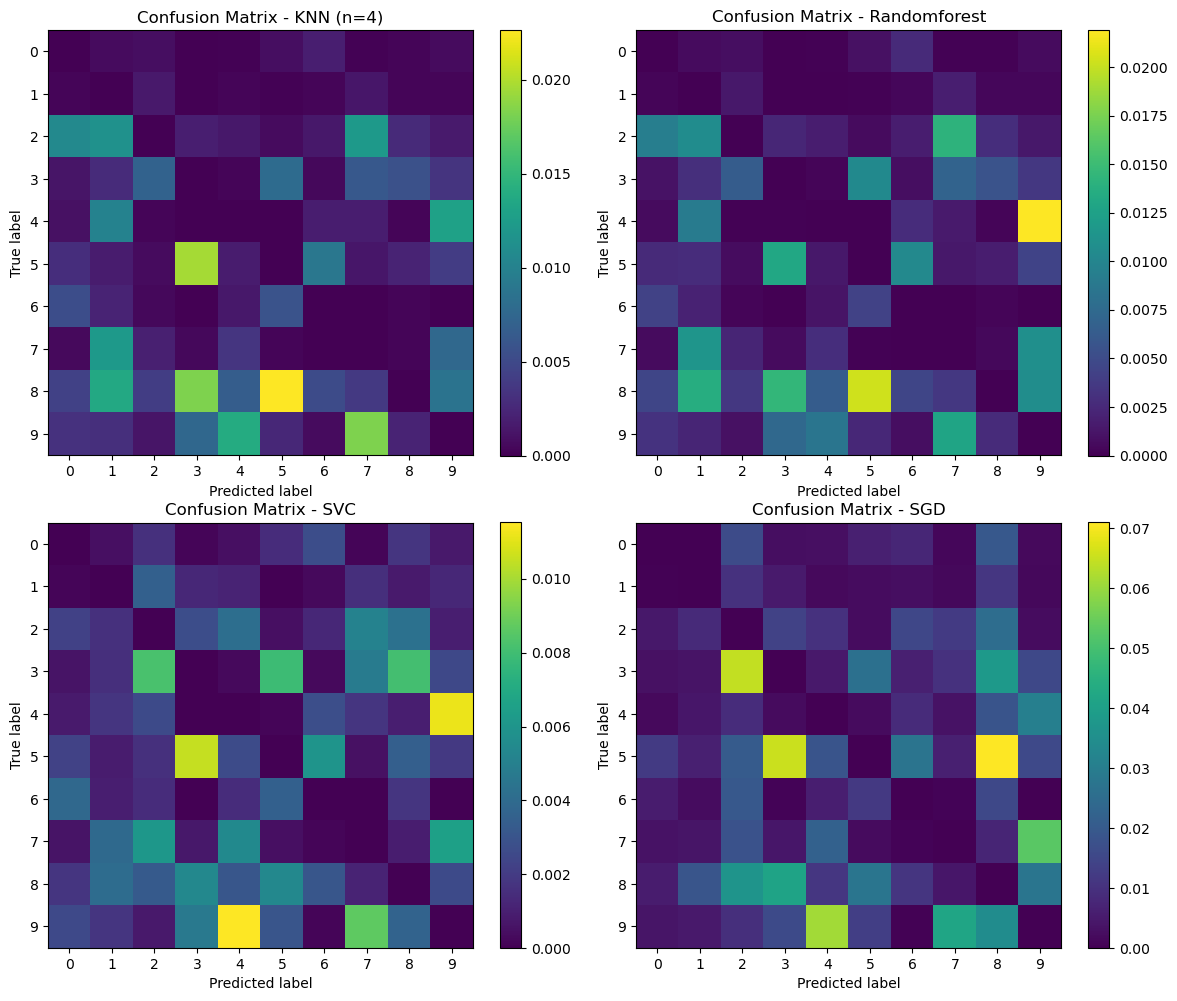

In [150]:
row_sums = cf_matrix_sgd.sum(axis=1, keepdims=True)
cf_matrix_sgd_norm = cf_matrix_sgd/row_sums
np.fill_diagonal(cf_matrix_sgd_norm,0)

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ConfusionMatrixDisplay(cf_matrixnorm).plot(ax=ax[0,0], include_values=False)
ax[0,0].set_title("Confusion Matrix - KNN (n=4)")
ConfusionMatrixDisplay(cf_matrix_rf_norm).plot(ax=ax[0,1], include_values=False)
ax[0,1].set_title("Confusion Matrix - Randomforest")
ConfusionMatrixDisplay(cf_matrix_svc_norm).plot(ax=ax[1,0], include_values=False)
ax[1,0].set_title("Confusion Matrix - SVC")
ConfusionMatrixDisplay(cf_matrix_sgd_norm).plot(ax=ax[1,1], include_values=False)
ax[1,1].set_title("Confusion Matrix - SGD")
plt.tight_layout()

So from this we are clear that we will only include the first 3 models (knn n=4, svc, randomforest)<br/>
now let's define a new classifier using sklearn baseEstimator which will combine these 3 models<br/>
we will also inherit classifier mixin to get other utilities such as score, predict, fit, ...

In [25]:
class weightedCombinedClassifier(BaseEstimator, ClassifierMixin):
    """estimators : list of classifiers"""
    """priority : index of an estimator : the classifier will predict the class which is predicted by more number of estimator 
       in case where the number of votes for each class is same it will predict the class for which this estimator has voted
    """
    def __init__(self, estimators, priority):
        self.estimators = estimators
        self.priority = priority
        self.prediction_type = 0

    def fit(self, X, y):
        for estimator in self.estimators:
            estimator.fit(X,y)
        return self

    def predict(self, X):
        if self.prediction_type == 1:
            return self.predict_single(self.priority, X)
        
        predictions = np.asarray([estimator.predict(X) for estimator in self.estimators]).T
        majority_vote = np.zeros(X.shape[0], dtype=int)
        for i, pred in enumerate(predictions):
            # Count the votes for each class
            (values, counts) = np.unique(pred, return_counts=True)
            max_count = np.max(counts)
            
            # Check if there is a tie
            if len(counts[counts == max_count]) > 1:
                # In case of tie, use priority estimator's vote
                majority_vote[i] = pred[self.priority]
            else:
                # Otherwise, predict the class with the most votes
                majority_vote[i] = values[np.argmax(counts)]
        return majority_vote

    def predict_single(self, index, X):
        return self.estimators[index].predict(X)
    

In [13]:
knn4_classifier = KNeighborsClassifier(n_neighbors=4)
rf_classifier = RandomForestClassifier(n_estimators=200, verbose=1)
svc_classifier = SVC(verbose=1)

ensemble_model = weightedCombinedClassifier([knn4_classifier, rf_classifier, svc_classifier], 2)

ensemble_model.fit(x_train_sharp_norm, y_train_sharp_norm)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   10.9s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   43.5s


[LibSVM]*
optimization finished, #iter = 345
obj = -58.313197, rho = -0.631838
nSV = 203, nBSV = 49
*.*
optimization finished, #iter = 1268
obj = -229.995546, rho = 0.558601
nSV = 680, nBSV = 215
*.*
optimization finished, #iter = 1193
obj = -179.026534, rho = 0.286893
nSV = 599, nBSV = 140
*
optimization finished, #iter = 849
obj = -127.922887, rho = 0.023106
nSV = 440, nBSV = 96
.*
optimization finished, #iter = 1550
obj = -252.946460, rho = 0.361470
nSV = 782, nBSV = 220
*.*
optimization finished, #iter = 1231
obj = -236.297496, rho = 0.117583
nSV = 651, nBSV = 208
*
optimization finished, #iter = 780
obj = -120.583720, rho = -0.136718
nSV = 406, nBSV = 96
*.*
optimization finished, #iter = 1206
obj = -215.364880, rho = 0.232579
nSV = 636, nBSV = 185
*.*
optimization finished, #iter = 1020
obj = -180.254409, rho = 0.058231
nSV = 527, nBSV = 161
*.*
optimization finished, #iter = 1004
obj = -219.510995, rho = 1.734340
nSV = 537, nBSV = 221
*
optimization finished, #iter = 988
obj = -

weightedCombinedClassifier(estimators=[KNeighborsClassifier(n_neighbors=4),
                                       RandomForestClassifier(n_estimators=200,
                                                              verbose=1),
                                       SVC(verbose=1)],
                           priority=2)

In [17]:
y_pred = ensemble_model.predict(x_test_sharp_norm)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


0.9824285714285714

0.9822569573712409

0.9823796192289995

0.9821698094225493

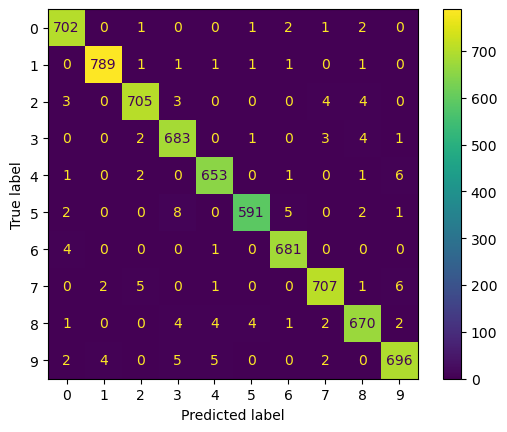

In [18]:
y_test_sharp_norm_int = y_test_sharp_norm.astype(int)
display(accuracy_score(y_test_sharp_norm_int, y_pred))
cf_matrix_final = confusion_matrix(y_test_sharp_norm_int, y_pred)
ConfusionMatrixDisplay(cf_matrix_final).plot()
display(f1_score(y_test_sharp_norm_int, y_pred, average='macro'))
display(precision_score(y_test_sharp_norm_int, y_pred, average='macro'))
display(recall_score(y_test_sharp_norm_int, y_pred, average='macro'))

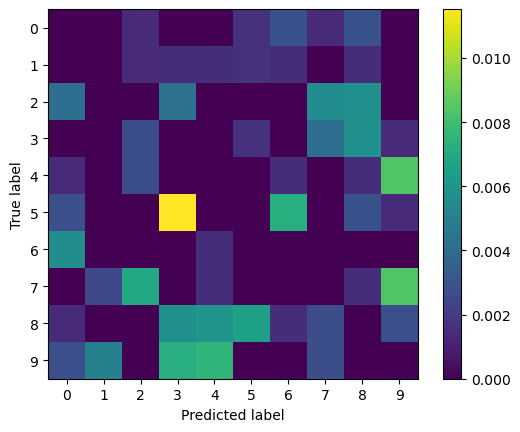

In [19]:
row_sum = cf_matrix_final.sum(axis=1)
cf_matrix_final_norm = cf_matrix_final/row_sum
np.fill_diagonal(cf_matrix_final_norm, 0)
ConfusionMatrixDisplay(cf_matrix_final_norm).plot(include_values=False)

In [20]:
y_pred_test_svc = ensemble_model.predict_single(2, x_test_sharp_norm)

0.9844285714285714

0.9842508930243064

0.9842689313234938

0.9842491806810161

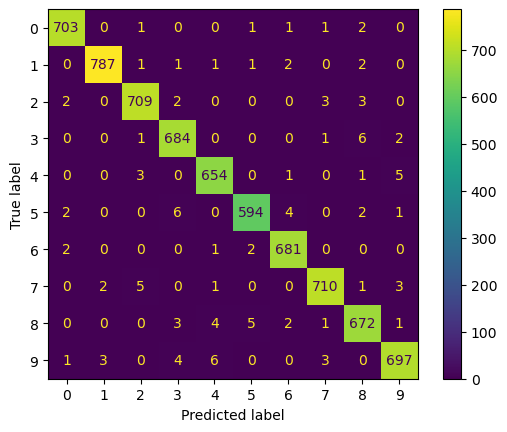

In [21]:
display(accuracy_score(y_test_sharp_norm, y_pred_test_svc))
cf_matrix_svc_test = confusion_matrix(y_test_sharp_norm, y_pred_test_svc)
ConfusionMatrixDisplay(cf_matrix_svc_test).plot()
display(f1_score(y_test_sharp_norm, y_pred_test_svc, average='macro'))
display(precision_score(y_test_sharp_norm, y_pred_test_svc, average='macro'))
display(recall_score(y_test_sharp_norm, y_pred_test_svc, average='macro'))

0.9721465067719259

0.9727640597706735

0.9717974444526319

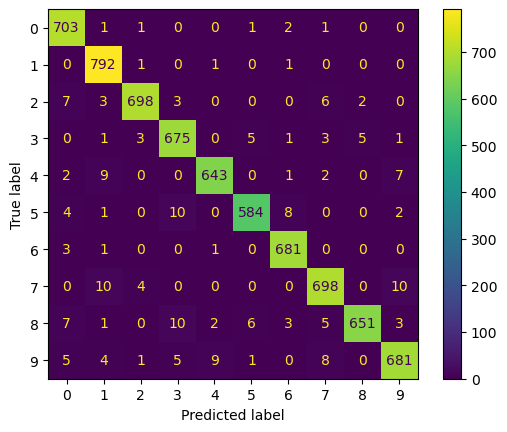

In [24]:
y_pred_knn = ensemble_model.predict_single(0, x_test_sharp_norm)
cf_matrix_knn_test = confusion_matrix(y_test_sharp_norm, y_pred_knn)
ConfusionMatrixDisplay(cf_matrix_knn_test).plot()
display(f1_score(y_test_sharp_norm, y_pred_knn, average='macro'))
display(precision_score(y_test_sharp_norm, y_pred_knn, average='macro'))
display(recall_score(y_test_sharp_norm, y_pred_knn, average='macro'))

Creating a pipeling for this process

first make a custom transformer that will transform the data

In [45]:
class sharpenNormalize(BaseEstimator, TransformerMixin):
    def sharpen_image(self, row):
        dig = row.to_numpy().reshape(28,28)
        kernel = np.array([[0, -1, 0],
                           [-1, 11, -1],
                           [0, -1, 0]
        ])
        img_rgb = cv.cvtColor(dig.astype(np.uint8),cv.COLOR_GRAY2RGB)
        img_sharpen = cv.filter2D(img_rgb,-1,kernel)
        img_sharp_gray = cv.cvtColor(img_sharpen, cv.COLOR_RGB2GRAY)
        return img_sharp_gray.flatten()
    
    def normalize(self, row):
        return row.astype('float32')/255
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        x_transformed = X.copy()
        x_transformed = X.progress_apply(self.sharpen_image, axis=1, result_type="broadcast")
        return self.normalize(x_transformed)

In [46]:
knn4_classifier = KNeighborsClassifier(n_neighbors=4)
rf_classifier = RandomForestClassifier(n_estimators=200, verbose=1)
svc_classifier = SVC(verbose=1)

ensemble_model = weightedCombinedClassifier([knn4_classifier, rf_classifier, svc_classifier], 2)
transformer = sharpenNormalize()

main_pipeline = Pipeline(steps= [
    ('sharpenNormalize', transformer),
    ('model', ensemble_model)
])

set_config(display='diagram')
display(main_pipeline)

Pipeline(steps=[('sharpenNormalize', sharpenNormalize()),
                ('model',
                 weightedCombinedClassifier(estimators=[KNeighborsClassifier(n_neighbors=4),
                                                        RandomForestClassifier(n_estimators=200,
                                                                               verbose=1),
                                                        SVC(verbose=1)],
                                            priority=2))])

In [31]:
x_train, x_test, y_train, y_test = x.iloc[:63000,:], x.iloc[63000:,:], y.iloc[:63000], y.iloc[63000:]

In [47]:
main_pipeline.fit(x_train, y_train)

100%|██████████| 63000/63000 [00:05<00:00, 11004.85it/s]
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   11.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   43.3s


[LibSVM]*
optimization finished, #iter = 345
obj = -58.313197, rho = -0.631838
nSV = 203, nBSV = 49
*.*
optimization finished, #iter = 1268
obj = -229.995546, rho = 0.558601
nSV = 680, nBSV = 215
*.*
optimization finished, #iter = 1193
obj = -179.026534, rho = 0.286893
nSV = 599, nBSV = 140
*
optimization finished, #iter = 849
obj = -127.922887, rho = 0.023106
nSV = 440, nBSV = 96
.*
optimization finished, #iter = 1550
obj = -252.946460, rho = 0.361470
nSV = 782, nBSV = 220
*.*
optimization finished, #iter = 1231
obj = -236.297496, rho = 0.117583
nSV = 651, nBSV = 208
*
optimization finished, #iter = 780
obj = -120.583720, rho = -0.136718
nSV = 406, nBSV = 96
*.*
optimization finished, #iter = 1206
obj = -215.364880, rho = 0.232579
nSV = 636, nBSV = 185
*.*
optimization finished, #iter = 1020
obj = -180.254409, rho = 0.058231
nSV = 527, nBSV = 161
*.*
optimization finished, #iter = 1004
obj = -219.510995, rho = 1.734340
nSV = 537, nBSV = 221
*
optimization finished, #iter = 988
obj = -

Pipeline(steps=[('sharpenNormalize', sharpenNormalize()),
                ('model',
                 weightedCombinedClassifier(estimators=[KNeighborsClassifier(n_neighbors=4),
                                                        RandomForestClassifier(n_estimators=200,
                                                                               verbose=1),
                                                        SVC(verbose=1)],
                                            priority=2))])

In [ ]:
y_pred = main_pipeline.predict(x_test)

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cf_matrix).plot()
display(f1_score(y_test, y_pred, average='macro'))
display(precision_score(y_test, y_pred, average='macro'))
display(recall_score(y_test, y_pred, average='macro'))